In [2]:
#Loading Unet and other libraries
from unet import simple_unet_model
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify

In [3]:
# Standard
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Utils
import h5py

In [4]:
f = h5py.File(r"../Dataset_list/train_image_dataset.hdf5", "r")

In [4]:
frames4ch = f["train 4ch frames"][:,:,:,:]
masks4ch = f["train 4ch masks"][:,:,:,:]

In [5]:
from sklearn.model_selection import train_test_split
train_frames, test_frames, train_masks, test_masks = train_test_split(frames4ch, masks4ch)

In [6]:
print(train_frames.shape)
print(test_frames.shape)

(600, 256, 256, 1)
(200, 256, 256, 1)


In [7]:
IMG_HEIGHT = train_frames.shape[1]
IMG_WIDTH  = train_frames.shape[2]
IMG_CHANNELS = train_frames.shape[3]

In [8]:
print(IMG_HEIGHT)

256


In [9]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

2022-06-20 22:15:04.757392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 22:15:04.804949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-20 22:15:04.804966: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-20 22:15:04.805760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 256)  0           ['conv2d_transpose[0][0]',       
                                                                  'conv2d_7[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 128)  295040      ['concatenate[0][0]']            
                                                                                                  
 dropout_5 (Dropout)            (None, 32, 32, 128)  0           ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 128)  147584      ['dropout_5[0][0]']              
                                                                                                  
 conv2d_tr

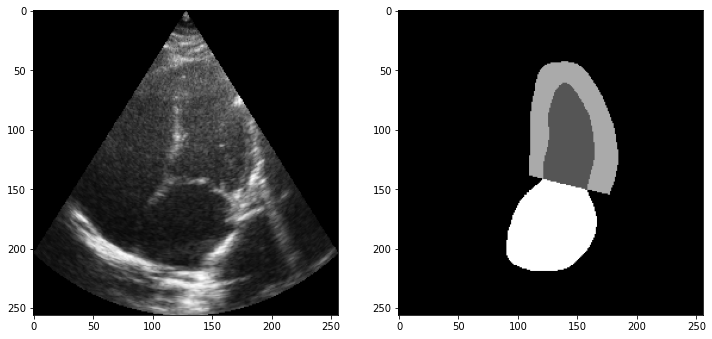

In [10]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(train_frames))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(train_frames[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(train_masks[image_number], (256, 256)), cmap='gray')
plt.show()

In [11]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=0,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

In [12]:
mask_data_gen_args = dict(rotation_range=0,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

In [13]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(train_frames, augment=True, seed=seed)

In [14]:
image_generator = image_data_generator.flow(train_frames, seed=seed)
valid_img_generator = image_data_generator.flow(test_frames, seed=seed)

In [15]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(train_masks, augment=True, seed=seed)

In [16]:
mask_generator = mask_data_generator.flow(train_masks, seed=seed)
valid_mask_generator = mask_data_generator.flow(test_masks, seed=seed)

In [17]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [18]:
my_generator = my_image_mask_generator(image_generator, mask_generator)

In [19]:
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [20]:
x = image_generator.next()
y = mask_generator.next()

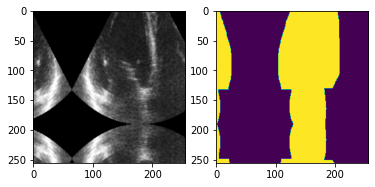

In [21]:

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [22]:
batch_size = 16
steps_per_epoch = 3*(len(train_frames))//batch_size

In [23]:
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=50)

Epoch 1/50
112/112 [==============================] - 733s 7s/step - loss: 1.1616 - accuracy: 0.7215 - val_loss: 0.4146 - val_accuracy: 0.7567
Epoch 2/50
112/112 [==============================] - 768s 7s/step - loss: 0.4042 - accuracy: 0.7530 - val_loss: 0.4056 - val_accuracy: 0.7574
Epoch 3/50
112/112 [==============================] - 749s 7s/step - loss: 0.4074 - accuracy: 0.7544 - val_loss: 0.4058 - val_accuracy: 0.7599
Epoch 4/50
112/112 [==============================] - 724s 6s/step - loss: 0.3970 - accuracy: 0.7561 - val_loss: 0.4027 - val_accuracy: 0.7586
Epoch 5/50
112/112 [==============================] - 710s 6s/step - loss: 0.3955 - accuracy: 0.7551 - val_loss: 0.4075 - val_accuracy: 0.7591
Epoch 6/50
112/112 [==============================] - 710s 6s/step - loss: 0.3663 - accuracy: 0.7557 - val_loss: 0.3872 - val_accuracy: 0.7574
Epoch 7/50
112/112 [==============================] - 704s 6s/step - loss: 0.3275 - accuracy: 0.8176 - val_loss: 0.3273 - val_accuracy: 0.8496

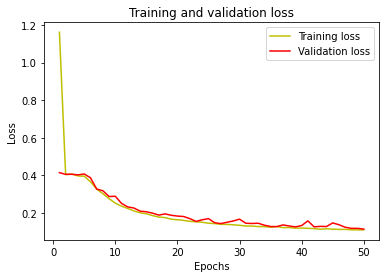

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

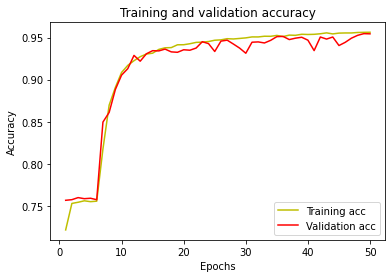

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
model.save_weights("..Trained_Model/unet_4ch.h5")